# Globular Clusters Random Forest Predictor V1

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

### Load/Prep Data

In [2]:
data_path='.'
df=pd.read_csv(f'{data_path}/merged.csv')
df.head(10)

,Fe/H,O/Fe,Na/Fe,F275W,F336W,F438W,F606W,F814W
0,-1.185,-0.004,0.169,19.5093,16.8509,-99.9999,12.0358,10.6808
1,-1.236,-0.047,0.737,-99.9999,-99.9999,-99.9999,13.2077,12.2431
2,-1.207,NaN,0.502,18.7742,-99.9999,14.8646,13.2423,12.2932
3,-1.213,0.302,0.247,18.6949,15.9644,15.0652,13.5954,12.6846
4,-1.335,-0.171,0.571,23.2479,21.7421,21.8567,20.4380,19.5103
5,-1.317,0.047,0.564,18.5220,16.0096,15.0788,13.6055,12.7164
6,-1.183,0.377,0.191,18.6844,16.0361,15.1303,13.6223,12.7163
7,-1.266,0.128,0.521,18.4185,-99.9999,-99.9999,13.8062,12.9295
8,-1.190,-0.352,0.738,-99.9999,-99.9999,-99.9999,13.9489,13.0931
9,-1.253,0.049,0.669,18.3557,16.1687,15.4939,14.1916,13.3550


In [3]:
print(df.shape)
df.describe()

(358, 8)


,Fe/H,O/Fe,Na/Fe,F275W,F336W,F438W,F606W,F814W
count,358.000000,273.000000,341.000000,307.000000,305.000000,308.000000,357.000000,358.000000
mean,-1.367316,0.118037,0.290610,10.827388,7.505343,6.776900,13.826913,12.800547
std,0.549118,0.328355,0.263252,30.889609,32.210170,31.823335,10.645904,10.539922
min,-2.425000,-0.913000,-0.420000,-99.999900,-99.999900,-99.999900,-99.999900,-99.999900
25%,-1.586250,-0.047000,0.103000,17.881850,15.868200,15.008800,13.849900,12.732650
50%,-1.318500,0.184000,0.300000,18.623500,16.782500,15.919900,14.533100,13.467700
75%,-1.121500,0.353000,0.449000,19.983150,17.313500,16.666300,15.295900,14.363225
max,-0.398000,0.761000,1.384000,24.894800,23.881700,24.689600,23.794100,22.318000


Minimum values seem like filler, need to find better replacement. For now, just use NaNs, which random forests are supposed to handle well

In [4]:
myfiller=np.min(df['F275W'])
df=df.replace(myfiller, np.nan)

Now that we have properly ID'd data we have vs do not, let's do some basic processing. want to use one values as magnitude, others as color. Start trying 438 since it is in middle

In [5]:
initial_columns=['F275W', 'F336W', 'F438W', 'F606W', 'F814W']
y_columns=['Fe/H', 'O/Fe', 'Na/Fe']
X_columns=[]

for i in range(len(initial_columns)-1):
    column0, column1=initial_columns[i], initial_columns[i+1]
    new_column=f'{column0}-{column1}'
    X_columns.append(new_column)
    df[new_column]=df[column0]-df[column1]
X_columns.append('F438W')

### Filter NaNs

"Because trees handle missing values natively there is no need for an imputer" CHECK HOW THIS IS DONE

Still need to filter out y-values with NaNs. SOme methods also need both x and y NaNs filtered, so we will make both datasets here:

In [6]:
df_dropna_y=df.dropna(subset=y_columns)
df_dropna=df.dropna()

Eventually want something better to preserve data as much as possible; maybe train to predict based on existing abundances? For now just take rows out when necessary.

In [7]:
X, y=df_dropna_y[X_columns], df_dropna_y[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test.describe()

,F275W-F336W,F336W-F438W,F438W-F606W,F606W-F814W,F438W
count,42.000000,43.000000,43.000000,53.000000,43.000000
mean,2.390331,1.034658,1.698553,1.043460,16.493530
std,0.801030,0.794434,0.644430,0.299229,1.769835
min,0.642000,-0.353600,0.670300,0.490500,13.800000
25%,1.677325,0.370550,1.250300,0.810100,15.527550
50%,2.445800,0.929600,1.548500,0.972400,16.132200
75%,3.003875,1.497050,2.002250,1.261200,17.147700
max,3.810400,2.917500,3.719500,1.838500,23.110000


Ok, so test data is not *terribly* small. 

# Try a Model

Lets try a very naive random forest:

In [8]:

randregress=RandomForestRegressor(
    n_estimators=10000,
    oob_score=True,
    max_depth=5,
    random_state=42, 
    n_jobs=-1)

randregress.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, n_estimators=10000, n_jobs=-1,
                      oob_score=True, random_state=42)

In [9]:
randregress.oob_score_

0.29086150560560925

Wow! Not very good. Quite likely that base features are not appropriate, should try PCA? Probably, but first, let's try gradient boost. This method does NOT accept NaNs in x-positions, I think because it needs to calculate residuals each time. So, need to drop MORE data....

# Try a NEW Model

In [10]:
X, y=df_dropna[X_columns], df_dropna[y_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.describe()
print(X_train.shape)

(166, 5)


In [11]:
gradientboost=GradientBoostingRegressor(
    max_depth=5, learning_rate=0.05, n_estimators=10000, 
    subsample=0.6,  
    n_iter_no_change=10, random_state=42)

GradientBoost is not multivariate; you can use a wrapper to train it on multible variables "at the same time" but it is still not true multivariate, just several single variates. 

In [12]:
multi_output_model = MultiOutputRegressor(estimator=gradientboost)
multi_output_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         n_estimators=10000,
                                                         n_iter_no_change=10,
                                                         random_state=42,
                                                         subsample=0.6))

In [13]:
oob_scores = [estimator.oob_score_ for estimator in multi_output_model.estimators_]
print(oob_scores)

[np.float64(0.012332329725219747), np.float64(0.026682489416623687), np.float64(0.036723662084453684)]


Oh my God even worse

In [14]:
n_estimators=[estimator.n_estimators_ for estimator in multi_output_model.estimators_]
print(n_estimators)

[52, 27, 18]


# Modified Random Forest Regression

By default, each *classifier* tree uses sqrt(N) features available, which for us is only like 2. But it does make the model more robust, and we can always add more trees, since our current optimum is like 50. 

In [15]:
randregress_sqrt=RandomForestRegressor(
    n_estimators=10000,
    oob_score=True,
    max_depth=5,
    max_features='sqrt',
    random_state=42, 
    n_jobs=-1)

randregress_sqrt.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=10000,
                      n_jobs=-1, oob_score=True, random_state=42)

In [16]:
randregress_sqrt.oob_score_

0.3066091527965467

Ok that did technically do better than using the full features.

# Learning Curves

Check how each model progresses as it gets more data

In [17]:
randregress=RandomForestRegressor(
    n_estimators=10000,
    oob_score=True,
    max_depth=5,
    random_state=42, 
    n_jobs=-1)

randregress_sqrt=RandomForestRegressor(
    n_estimators=10000,
    oob_score=True,
    max_depth=5,
    max_features='sqrt',
    random_state=42, 
    n_jobs=-1)


gradientboost=GradientBoostingRegressor(
    max_depth=5, learning_rate=0.05, n_estimators=10000, 
    subsample=0.6,  
    n_iter_no_change=10, random_state=42)
multi_output_model = MultiOutputRegressor(estimator=gradientboost)

models=[randregress, randregress_sqrt, multi_output_model]
labels=['full features', 'sqrt features', 'gradient boost = (']
colors=['blue', 'orange', 'red']

In [18]:
%%skip
train_errors_list=[]
valid_errors_list=[]
for i in range(3):
    train_sizes, train_scores, valid_scores = learning_curve(
        models[i], X, y, cv=5, scoring="neg_root_mean_squared_error"
    )
    train_errors = -train_scores.mean(axis=1)
    valid_errors = -valid_scores.mean(axis=1)
    train_errors_list.append(train_errors)
    valid_errors_list.append(valid_errors)
    print(i)

In [19]:
%%skip
plt.clf()
plt.ylabel('RMSE')
for i in range(3):
    plt.plot(train_sizes, train_errors_list[i], color=colors[i], linestyle=':', linewidth=2, label=labels[i])
    plt.plot(train_sizes, valid_errors_list[i], color=colors[i], linewidth=3, label=labels[i])
plt.legend()
plt.savefig('./Plots/LearningCurve.png')

# Predictions

In [20]:
for i in range(3):
    models[i].fit(X_train, y_train)

y_pred=[pd.DataFrame(models[i].predict(X_test), columns=y_test.columns, index=y_test.index) for i in range(3)]

<Figure size 640x480 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

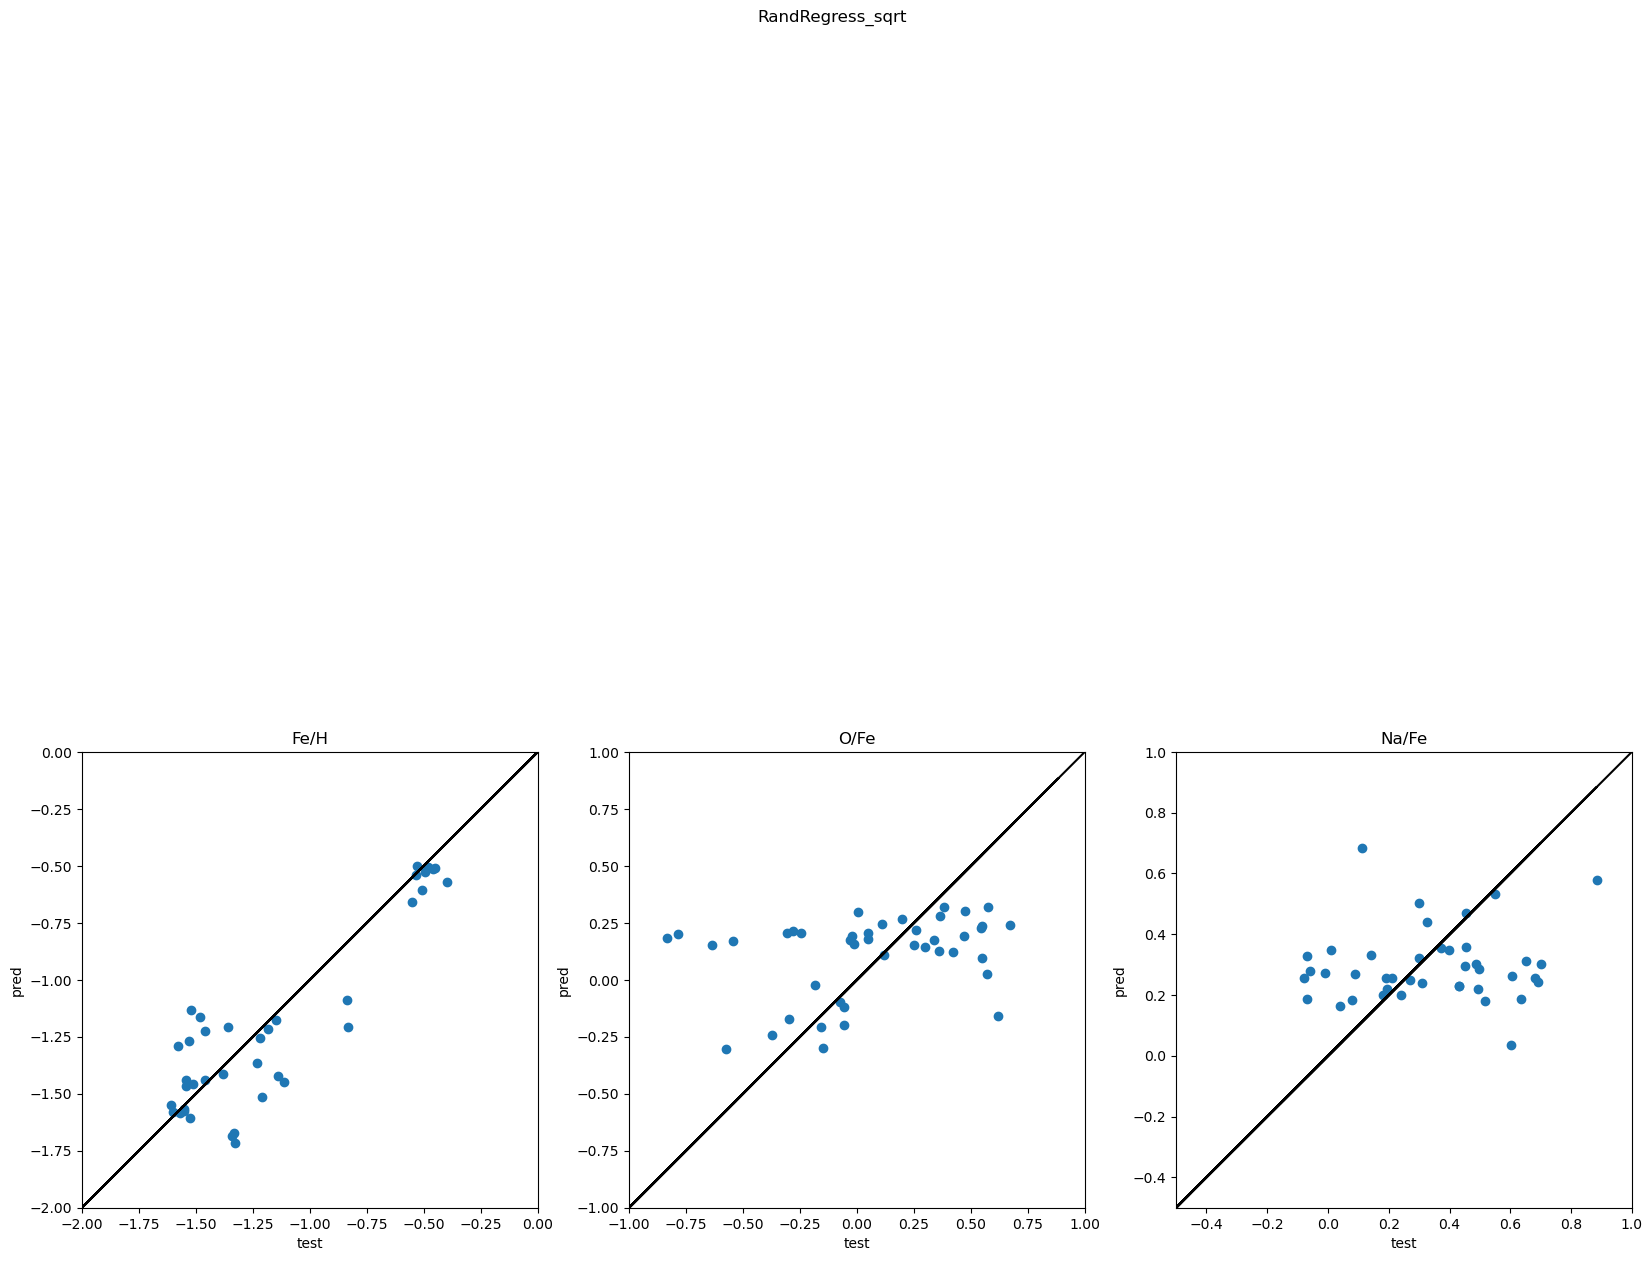

In [44]:
targets=y_test.columns
lims=[(-2, 0), (-1, 1), (-0.5, 1)]
plt.clf()
fig, ax=plt.subplots(1, 3, figsize=(20, 20))
fig.suptitle('RandRegress_sqrt')
for i in range(3):
    ax[i].set_title(targets[i])
    ax[i].set_xlabel('test')
    ax[i].set_ylabel('pred')
    ax[i].plot(y_test, y_test, color='black')
    ax[i].scatter(y_test[targets[i]], y_pred[1][targets[i]])
    ax[i].set_xlim(*lims[i])
    ax[i].set_ylim(*lims[i])
    ax[i].set_aspect('equal')
plt.show()
#plt.savefig('./Plots/test_pred_randregress_sqrt_v1.png')

In [22]:
targets[i]

'Na/Fe'